# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# **Data Loading and Preprocessing**

In [ ]:
# Transform: convert images to tensors and normalize pixel values between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.62MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.0MB/s]

Training samples: 48000, Validation samples: 12000, Test samples: 10000


# **Define the ANN Model**

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten image
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# **Define the CNN Model**

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # After one pooling, image size: 28x28 → 14x14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# **Training and Evaluation Functions**

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.3f}, Val Loss: {epoch_val_loss:.3f}, "
              f"Train Acc: {epoch_train_acc:.2f}%, Val Acc: {epoch_val_acc:.2f}%")

    return train_losses, val_losses, train_acc, val_acc

# **Train ANN**

In [ ]:
ann_model = ANN_Model()
print("\nTraining ANN Model")
ann_train_loss, ann_val_loss, ann_train_acc, ann_val_acc = train_model(ann_model, train_loader, val_loader, epochs=10)


Training ANN Model
Epoch [1/10] Train Loss: 0.541, Val Loss: 0.422, Train Acc: 80.41%, Val Acc: 84.69%
Epoch [2/10] Train Loss: 0.406, Val Loss: 0.405, Train Acc: 85.06%, Val Acc: 85.06%
Epoch [3/10] Train Loss: 0.373, Val Loss: 0.368, Train Acc: 86.19%, Val Acc: 86.78%
Epoch [4/10] Train Loss: 0.345, Val Loss: 0.348, Train Acc: 87.33%, Val Acc: 87.19%
Epoch [5/10] Train Loss: 0.327, Val Loss: 0.343, Train Acc: 87.78%, Val Acc: 87.13%
Epoch [6/10] Train Loss: 0.315, Val Loss: 0.344, Train Acc: 88.35%, Val Acc: 87.43%
Epoch [7/10] Train Loss: 0.301, Val Loss: 0.336, Train Acc: 88.87%, Val Acc: 87.81%
Epoch [8/10] Train Loss: 0.289, Val Loss: 0.318, Train Acc: 89.09%, Val Acc: 88.77%
Epoch [9/10] Train Loss: 0.282, Val Loss: 0.334, Train Acc: 89.53%, Val Acc: 88.08%
Epoch [10/10] Train Loss: 0.272, Val Loss: 0.322, Train Acc: 89.69%, Val Acc: 88.41%


# **Train CNN**

In [ ]:
cnn_model = CNN_Model()
print("\nTraining CNN Model")
cnn_train_loss, cnn_val_loss, cnn_train_acc, cnn_val_acc = train_model(cnn_model, train_loader, val_loader, epochs=10)


Training CNN Model
Epoch [1/10] Train Loss: 0.400, Val Loss: 0.299, Train Acc: 85.70%, Val Acc: 89.02%
Epoch [2/10] Train Loss: 0.250, Val Loss: 0.236, Train Acc: 90.91%, Val Acc: 91.46%
Epoch [3/10] Train Loss: 0.196, Val Loss: 0.230, Train Acc: 92.72%, Val Acc: 91.83%
Epoch [4/10] Train Loss: 0.160, Val Loss: 0.209, Train Acc: 94.18%, Val Acc: 92.32%
Epoch [5/10] Train Loss: 0.129, Val Loss: 0.224, Train Acc: 95.22%, Val Acc: 92.47%
Epoch [6/10] Train Loss: 0.103, Val Loss: 0.232, Train Acc: 96.20%, Val Acc: 92.55%
Epoch [7/10] Train Loss: 0.084, Val Loss: 0.247, Train Acc: 96.90%, Val Acc: 92.41%
Epoch [8/10] Train Loss: 0.067, Val Loss: 0.263, Train Acc: 97.51%, Val Acc: 91.94%
Epoch [9/10] Train Loss: 0.056, Val Loss: 0.281, Train Acc: 97.91%, Val Acc: 92.29%
Epoch [10/10] Train Loss: 0.043, Val Loss: 0.300, Train Acc: 98.44%, Val Acc: 92.65%


# **Plot Accuracy and Loss Curves**

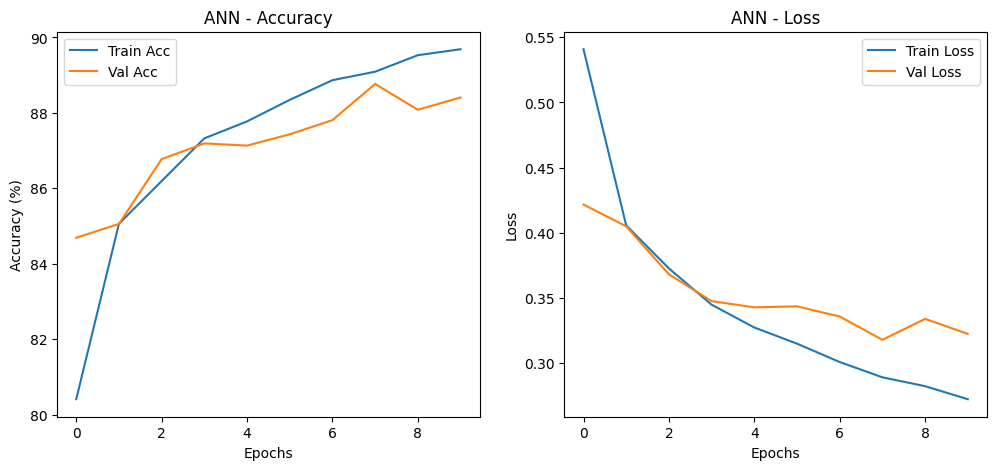

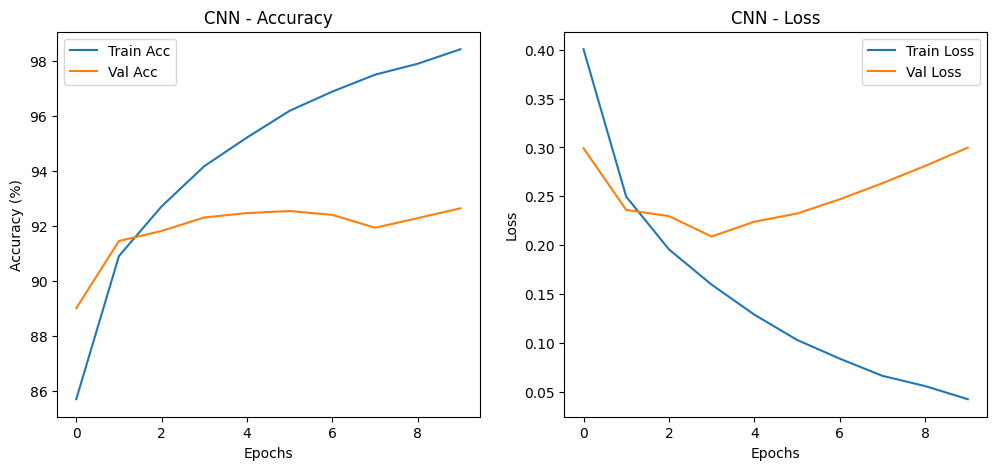

In [ ]:
def plot_curves(train_acc, val_acc, train_loss, val_loss, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_curves(ann_train_acc, ann_val_acc, ann_train_loss, ann_val_loss, "ANN")
plot_curves(cnn_train_acc, cnn_val_acc, cnn_train_loss, cnn_val_loss, "CNN")

# **Evaluate on Test Set**

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")
    return all_preds, all_labels

print("\nEvaluating ANN")
ann_preds, ann_labels = test_model(ann_model, test_loader)

print("\nEvaluating CNN")
cnn_preds, cnn_labels = test_model(cnn_model, test_loader)


Evaluating ANN
Test Accuracy: 87.88%

Evaluating CNN
Test Accuracy: 92.21%


# **Confusion Matrix Visualization**

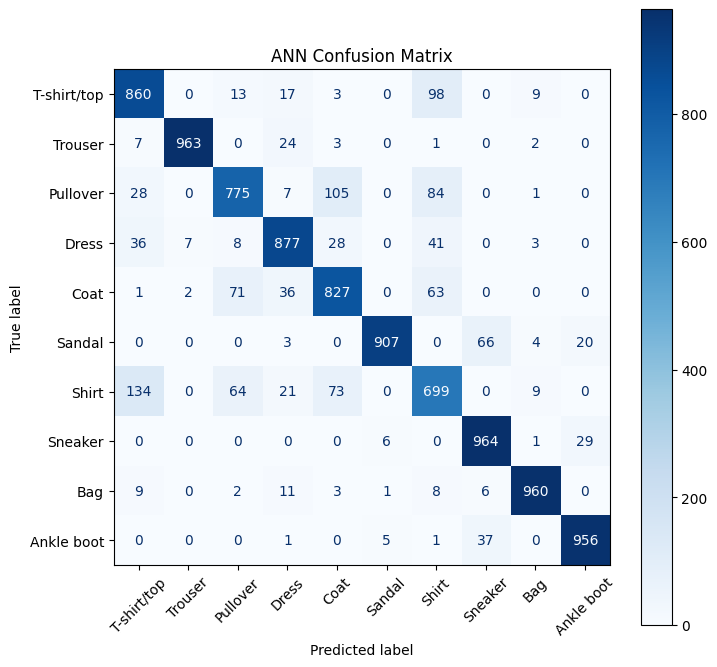

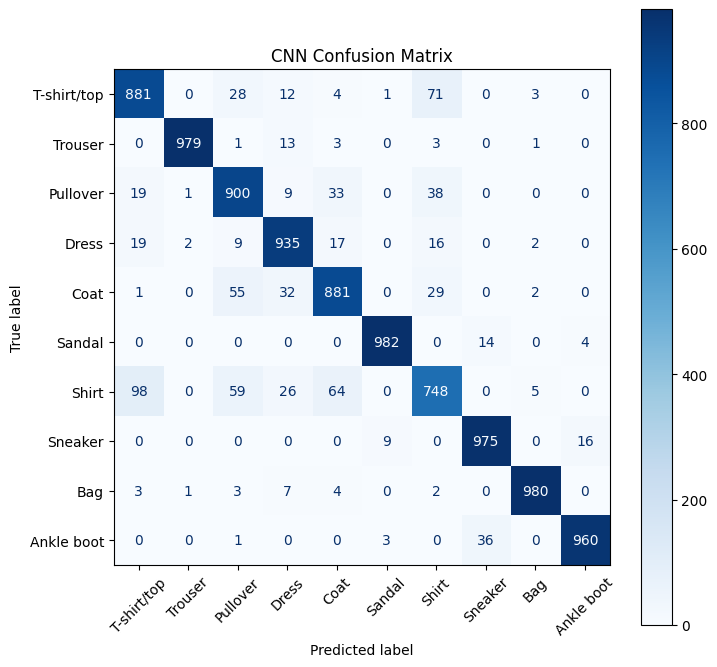

In [ ]:
# Class names from Fashion-MNIST dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.show()

plot_confusion_matrix(ann_labels, ann_preds, "ANN Confusion Matrix")
plot_confusion_matrix(cnn_labels, cnn_preds, "CNN Confusion Matrix")